In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

In [5]:
wine_data.shape

(178, 13)

In [6]:
print(wine_sklearn.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1



# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [7]:
# 1 point
def scale(X):
    # your code here
    features = X[X.columns].values
    norm_features = (features - features.mean(axis=0)) / features.std(axis=0)
    return norm_features

In [8]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [9]:
# 2 points with numpy
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, copy=True, with_mean=True, with_std=True):
        # your code here
        self.columns = None
        self.copy = copy
        self.with_mean = True
        self.with_std = True

    def fit(self, X, y=None):
        # your code here
        self.mean = np.mean(X)
        self.std = np.std(X, ddof=0)
        return self

    def transform(self, X, y=None, copy=None):
        # your code here
        return (X - self.mean) / self.std

In [10]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [11]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ -7.45445081,   0.87728545],
       [-16.12964248,  -0.49667322],
       [-15.58258265,  -0.53434073],
       ...,
       [ -0.67209317,   6.46250048],
       [ 11.49439873,   4.48735733],
       [  0.54611054,   4.62152908]])

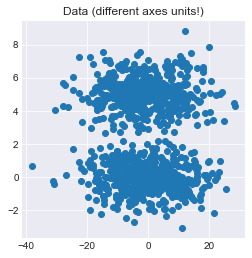

In [12]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

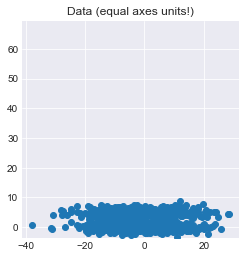

In [13]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

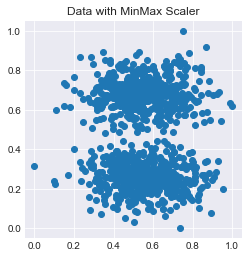

In [14]:
## your code
min_max_scaler = MinMaxScaler()
data_mm_scaled = min_max_scaler.fit_transform(data)
plot_scatter(data_mm_scaled[:, 0], data_mm_scaled[:, 1], auto_scaled=False, title='Data with MinMax Scaler')

### StandardScaler (0.5 point)

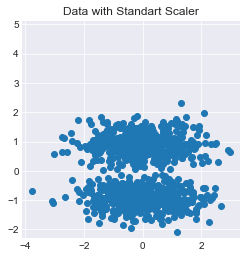

In [15]:
## your code
std_scaler = StandardScaler()
data_std_scaled = std_scaler.fit_transform(data)
plot_scatter(data_std_scaled[:, 0], data_std_scaled[:, 1], auto_scaled=False, title='Data with Standart Scaler')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


In [16]:
# import lib
from sklearn.cluster import KMeans

# clastering with unscaled data
kmeans_no_scale = KMeans(n_clusters=2).fit_predict(data)

# clastering with scaled data
std_scaler = StandardScaler()
data_std_scaled = std_scaler.fit_transform(data)
kmeans_scale = KMeans(n_clusters=2).fit_predict(data_std_scaled)

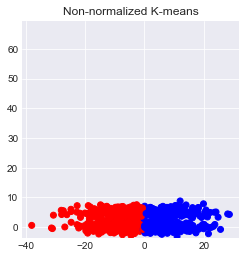

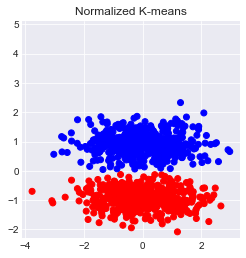

In [17]:
# visualisation with unscaled data
plot_scatter(x=data[:, 0], y=data[:, 1], clusters=kmeans_no_scale, auto_scaled=False, title='Non-normalized K-means')

# visualisation with scaled data
plot_scatter(x=data_std_scaled[:, 0], y=data_std_scaled[:, 1], clusters=kmeans_scale, auto_scaled=False, title='Normalized K-means')

As we can see Kmeans was not able to separete clusters when we use non-scaled data. The second model shows clear separate clusteds but it would not be easy to see on the more complex data

## Exercise  3 - Preprocessing Pipeline (2 points)

In [18]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

In [19]:
wine_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
138,13.49,3.59,2.19,19.5,88.0,1.62,0.48,0.58,0.88,5.70,0.81,1.82,580.0
104,12.51,1.73,1.98,20.5,85.0,2.20,1.92,0.32,1.48,2.94,1.04,3.57,672.0
78,12.33,0.99,1.95,14.8,136.0,1.90,1.85,0.35,2.76,3.40,1.06,2.31,750.0
36,13.28,1.64,2.84,15.5,110.0,2.60,2.68,0.34,1.36,4.60,1.09,2.78,880.0
93,12.29,2.83,2.22,18.0,88.0,2.45,2.25,0.25,1.99,2.15,1.15,3.30,290.0


In [20]:
wine_labels_train.head()

138    2
104    1
78     1
36     0
93     1
Name: target, dtype: int32

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [21]:
# model trained with raw data
log_reg_raw = LogisticRegression(solver='liblinear', penalty='l1')
log_reg_raw.fit(wine_train, wine_labels_train)
pred_raw_train = log_reg_raw.predict(wine_train)
pred_raw_val = log_reg_raw.predict(wine_val)
print(f'Logistic Regression on raw data (train): {accuracy_score(wine_labels_train, pred_raw_train)}')
print(f'Logistic Regression on raw data (val): {accuracy_score(wine_labels_val, pred_raw_val)}')

Logistic Regression on raw data (train): 0.967741935483871
Logistic Regression on raw data (val): 0.9814814814814815


In [22]:
# model trained after data was scaled
log_reg_stsc = Pipeline([
    ('scaler', StandardScaler()),
    ('clasifier', LogisticRegression(solver='liblinear', penalty='l1'))
])
log_reg_stsc.fit(wine_train, wine_labels_train)
pred_stsc_train = log_reg_stsc.predict(wine_train)
pred_stsc_val = log_reg_stsc.predict(wine_val)
print(f'Logistic Regression with Standard Scaler (train): {accuracy_score(wine_labels_train, pred_stsc_train)}')
print(f'Logistic Regression with Standard Scaler (val): {accuracy_score(wine_labels_val, pred_stsc_val)}')

Logistic Regression with Standard Scaler (train): 1.0
Logistic Regression with Standard Scaler (val): 0.9814814814814815


In [23]:
log_reg_mmsc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clasifier', LogisticRegression(solver='liblinear', penalty='l1'))
])
log_reg_mmsc.fit(wine_train, wine_labels_train)
pred_mmsc_train = log_reg_stsc.predict(wine_train)
pred_mmsc_val = log_reg_stsc.predict(wine_val)
print(f'Logistic Regression with MinMax Scaler (train): {accuracy_score(wine_labels_train, pred_mmsc_train)}')
print(f'Logistic Regression with MinMax Scaler (val): {accuracy_score(wine_labels_val, pred_mmsc_val)}')

Logistic Regression with MinMax Scaler (train): 1.0
Logistic Regression with MinMax Scaler (val): 0.9814814814814815


In [24]:
# model trained with scaling and feature selection
log_reg_sc_vt = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0.5)),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(solver='liblinear', penalty='l1'))
])
log_reg_sc_vt.fit(wine_train, wine_labels_train)
pred_train = log_reg_sc_vt.predict(wine_train)
pred_val = log_reg_sc_vt.predict(wine_val)
print(f'LogisticRegression with StandardScaler and VarianceThreshold (train): {accuracy_score(wine_labels_train, pred_train)}')
print(f'LogisticRegression with StandardScaler and VarianceThreshold (val): {accuracy_score(wine_labels_val, pred_val)}')

LogisticRegression with StandardScaler and VarianceThreshold (train): 0.967741935483871
LogisticRegression with StandardScaler and VarianceThreshold (val): 1.0


__Note:__  Feature scaling is an important part of the data preprocessing and some algorithm requared data normalization. Rescaling the features such that they have the properties of a standard normal distribution
with a mean of zero and a standard deviation of one. With the scaling I got higher accuracy on val=0.9814814814814815 and with the feature selection I even got on validation data set accuracy=1 with the threshold=0.5. With the threshold=0.8 both accuracy for train and test fall.

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

#Задать функцию которую минимизирушь,  условие достижения минимума, и нач. Вектор
Понял, np.cov по умолчанию строки это переменные, надо либо транспонированную матрицу подать, либо задать параметр rowvar=False


In [25]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

In [26]:
wine_data.shape

(178, 13)

In [27]:
wine_labels.shape

(178,)

Find a covariance matrix of standartized data and assing it to S.

In [28]:
## your code
std_scaler = StandardScaler()
data_scaled = std_scaler.fit_transform(wine_data)
S = np.cov(data_scaled, rowvar=False)

If your code is correct, the following assert should be Ok.

In [29]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [35]:
from scipy.optimize import minimize

def objective(x):
    return -x.T@S@x
    # your code: write objective of the problem (don't forget that scipy does min while we need max)

def norm_constraint(x):
    return np.linalg.norm(x) -1

con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.zeros((S.shape[0], 1), dtype=float)

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

In [36]:
x0@S@x0

4.7324371202988

Hurray! We have first vector! Let's do another one.

In [38]:
def orthogonality_constraint(x):
    # your code: x should be orthogonal to x0, function should return 0 if constraint holds
    return x@x0
con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.zeros((S.shape[0], 1), dtype=float)


sol = minimize(objective, 
               x1, 
               constraints = [con1, con2]
              )

x1 = sol.x

In [39]:
x1@S@x1

2.5110809431088774

If your solution is correct, the following asserts should be Ok.

In [40]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

In [70]:
x0_norm = np.linalg.norm(x0)
x0_norm

1.0000000162116778

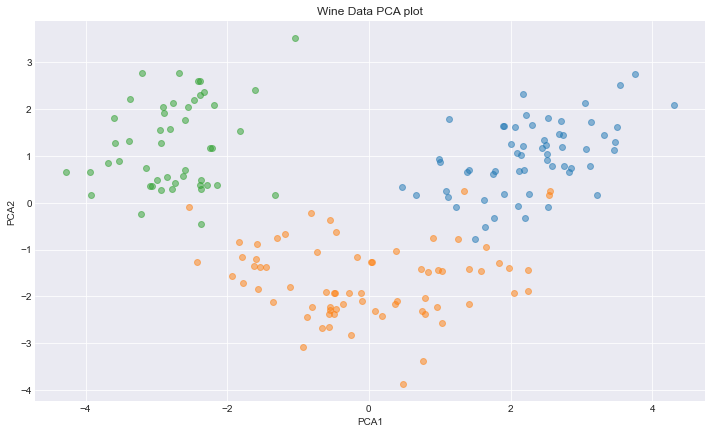

In [71]:
wine_data_pca = np.column_stack([data_scaled@x0, data_scaled@x1]) # multiply data by vectors from custom PCA
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))

ax.scatter(wine_data_pca[wine_labels == 0, 0], wine_data_pca[wine_labels == 0, 1], alpha=0.5)
ax.scatter(wine_data_pca[wine_labels == 1, 0], wine_data_pca[wine_labels == 1, 1], alpha=0.5)
ax.scatter(wine_data_pca[wine_labels == 2, 0], wine_data_pca[wine_labels == 2, 1], alpha=0.5)
ax.set_title('Wine Data PCA plot')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
plt.show()

All three classes visually devided in three clasters

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [54]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

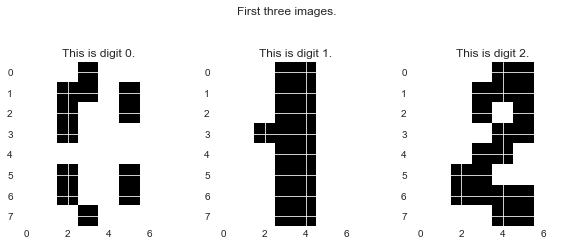

In [55]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [58]:
clf = RandomForestClassifier(max_depth=13)

# your code here

clf.fit(X_train, y_train)
pred = clf.predict(X_val)
acc = accuracy_score(y_val, pred)
print(acc)

0.9814814814814815


In [59]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [ ]:
# ! pip install boruta

In [60]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

# your code here: do run the boruta
# подается np.array utsu - number
# X_shadow = X_train.apply(np.random.permutation)
# X_shadow.columns = ['shadow_' + feat for feat in X_train.columns]
# X_boruta = pd.concat([X_train, X_shadow], axis = 1)
# feat_selector.fit(X_boruta, y_train)


X_filtered = feat_selector.fit_transform(X.values, y.values)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

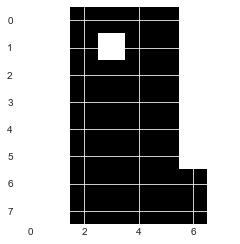

In [61]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [62]:
X.shape, X_filtered.shape

((537, 64), (537, 33))

In [63]:
# use filtered features to train model again
X_train, X_val, y_train, y_val = train_test_split(X_filtered, y, test_size=0.3, random_state=42)

In [66]:
clf = RandomForestClassifier(max_depth=13)

# your code here
clf.fit(X_train, y_train)
pred = clf.predict(X_val)
acc = accuracy_score(y_val, pred)
print(acc)

0.9938271604938271


In [67]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market